# Translating Data to Spikes

Suppose we have some data---whether an image, audio content, or some other form of information---and we want to represent it as spikes. In other words, we have some **external** data source and we want to "input" it into our neuromorphic system. How can we do this?

Let's start with something like a scalar number. How would we translate this into spikes? We could use either **frequency** encoding (where we send information by communicating with *how often* our neuron fires) or **time** encoding (where we send information through the precise *timing* of neuron fires). **Let's focus on frequency coding**.

A simple way would be to spike in proportion to the value of the number; the higher the number, the more spikes. So let's suppose we have a target number $v$ that we want to represent in spikes. If $v$ is positive, we can do this easily by translating $v$ into a **firing rate** (number of spikes per second). This would mean that we fire $v$ times per second...or once every $\frac{1}{v}$ seconds, if $v$ is positive.

In [2]:
import matplotlib.pyplot as plt

freq = 1

def plot_spikes(spikes, T, width=900, height=20, padding=1): # Show a plot of the spikes
    fig, ax = plt.subplots(figsize=(width/100, height/100)) # Create a new figure
    spacing = (width - 2 * padding) / T # The factor to multiply spike time by to get an x position
    
    spike_width = 2
    spike_height = height - 2 * padding
    y = padding
    
    for t in spikes:
        x = padding + t * spacing
        rect = plt.Rectangle((x, y), spike_width, spike_height, color='black')
        ax.add_patch(rect)
    
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.axis('off')  # Turn off the axis

    plt.show()

def simple_frequency_spikes(freq, T=100, dt=0.01): # Generate a list of spiking times
    spikes = []

    if freq > 0: # Since we divide by freq, we can't have freq = 0
        period = 1.0 / freq # The time between spikes
        steps_per_spike = int(period / dt) # The number of steps between spikes
        for step in range(int(T / dt)):
            if step % steps_per_spike == 0:
                t = step * dt
                spikes.append(t)
            
    return spikes, T

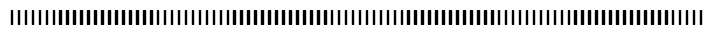

Spikes: 100 over 100 seconds (1.0 Hz)


In [3]:

spikes, T = simple_frequency_spikes(freq)
plot_spikes(spikes, T)
print(f"Spikes: {len(spikes)} over {T} seconds ({len(spikes) / T} Hz)")

:::{spikes-by-frequency}
:::

This works but has a few problems. First, it does not account for things like negative numbers (you can't have a negative frequency). So let's say that we assume that $v$ is in the range $[v_{min}, v_{max}]$. We can then scale our prior value of $v$ to be $v_s$ and ensure it is in the range $[0, 1]$: $v_s = \frac{v-v_{min}}{v_{max}-v_{min}}$.

Then, if we want it to use frequencies outside of $[0, 1]$ (say we want frequencies in the range $[f_{min}, f_{max}]$), we can do: $f_s(v) = f_{min} + v_s(f_{max}-f_{min}) = f_{min} + \frac{v-v_{min}}{v_{max}-v_{min}}(f_{max}-f_{min})$.

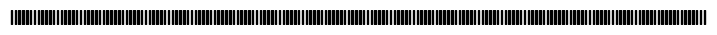

Spikes: 182 over 100 seconds (1.82 Hz)


In [4]:
def scaled_frequency_spikes(val, v_min=0, v_max=100, f_min=0.9, f_max=10, T=100, dt=0.01):
    return simple_frequency_spikes(f_min + (val - v_min) / (v_max - v_min) * (f_max - f_min), T, dt)

spikes, T = scaled_frequency_spikes(10, v_min=0, v_max=100)
plot_spikes(spikes, T)
print(f"Spikes: {len(spikes)} over {T} seconds ({len(spikes) / T} Hz)")

:::{scaled-spikes-by-frequency}
:::

This works but it has a few drawbacks. First, if we want regular spiking intervals then we need to have some notion of state in order to track if we should fire at a given timestep or not. Second, it does not contain any noise. Noise can help improve the robustness of our systems (and make them more realistic) by (1) ensuring that the system is recognizing common underlying patterns rather than overfitting to specific examples and (2) making sure it is more tolerant to errors and noisier inputs.

Instead, it is common to use Poisson processes to represent these data probabilistically. 

## Probabilistic Firing

We want to have a **probability** of firing that will likely result in firing rate $f_s(v)$. Like before, suppose we want to represent scalar $v$ with firing rate $f_s(v) = f_{min} + \frac{v-v_{min}}{v_{max}-v_{min}}(f_{max}-f_{min})$. To do this, we want to have a probability of $f_s(v)$ of firing every second. This means that in a discrete simulation with timesteps $T_{step}$, we should have a probability of firing as $f_s(v) T_{step}$ on every timestep:

$$Pr(fire) = T_{step}(f_{min} + \frac{v-v_{min}}{v_{max}-v_{min}}(f_{max}-f_{min}))$$

...then given a number of spikes $s$ over time $T_{step}$, our frequency is $\frac{s}{T_{step}}$ and we can estimate our value by solving for $\hat{x}$:

$$\hat{v} = \frac{\frac{s}{T_{step}}-f_{min}}{f_{max}-f_{min}}(v_{max} - v_{min}) + v_{min}$$

In [10]:
import random

def poisson_spikes(freq, T, dt=0.01):
    spikes = []
    probFire = freq * dt
    numSteps = int(T / dt)
    for step in range(numSteps):
        if random.random() < probFire:
            t = step * dt
            spikes.append(t)
    return spikes, T

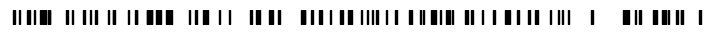

Spikes: 106 over 100 seconds (1.06 Hz). Estimated Value: 10.60 (Actual: 10; Error: 0.60)


In [11]:

def scaled_poission_spikes(val, val_min=0, val_max=100, f_min=0.9, f_max=10, T=100, dt=0.01):
    return poisson_spikes(f_min + (val - val_min) / (val_max - val_min) * (f_max - f_min), T, dt)

val   = 10
v_min = 0
v_max = 10
f_min = 0
f_max = 1
spikes, T = scaled_poission_spikes(val=val, val_min=v_min, val_max=v_max, f_min=f_min, f_max=f_max)
plot_spikes(spikes, T)
estimated_value = len(spikes) / T * (v_max - v_min) / (f_max - f_min) + v_min
print(f"Spikes: {len(spikes)} over {T} seconds ({len(spikes) / T:.2f} Hz). Estimated Value: {estimated_value:.2f} (Actual: {val}; Error: {abs(val - estimated_value):.2f})")

:::{poisson-spikes}
:::

Let's look at how the estimated value varies compared to the actual value when we do this. For now, we'll use the values `f_min = 0`, `f_max = 100`, `x_min = 0`, `x_max = 100`. We'll use a discrete time simulation with `Tstep = 0.01` for every step:

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_values(val_min, val_max, f_min=0, f_max=100, val_step = 0.01, T=10):
    estimated_values = []
    actual_values = []
    for val in np.arange(val_min, val_max, val_step):
        spikes, T = scaled_poission_spikes(val=val, val_min=val_min, val_max=val_max, f_min=f_min, f_max=f_max, T=T)
        estimated_value = len(spikes) / T * (val_max - val_min) / (f_max - f_min) + val_min
        estimated_values.append(estimated_value)
        actual_values.append(val)

    plt.figure()
    plt.plot(actual_values, estimated_values, color="black", linewidth=1)
    plt.plot(actual_values, actual_values, color="red", linewidth=1, linestyle="--")
    plt.xlabel("Actual Value")
    plt.ylabel("Estimated Value")
    plt.show()

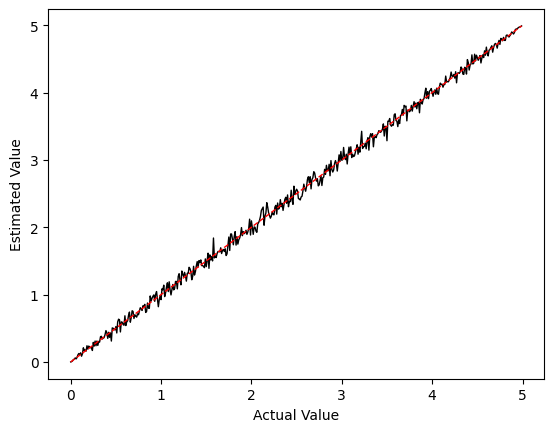

In [18]:
plot_values(0, 5, f_min=0, f_max=100)

We can see that our reconstructed estimates look fairly reasonable. Now let's look at what happens if we increase `f_max` to `200`:

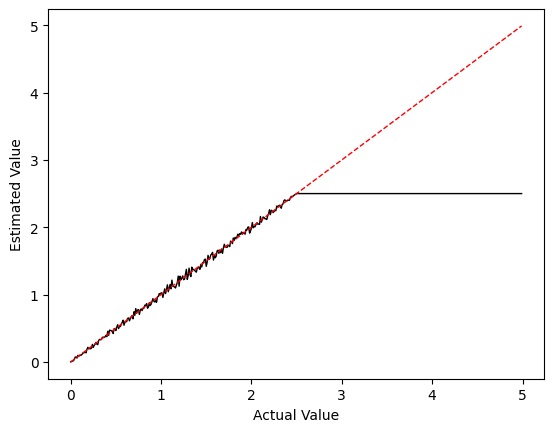

In [19]:
plot_values(0, 5, f_min=0, f_max=200)

Notice how our estimate stops increasing around `x = 2.5`? This corresponds to a frequency of 100 Hz. Given that we had a value of `Tstep = 0.01`, we can never achieve a frequency greater than $\frac{1}{T_{step}} = 100$ since we can only fire a maximum of one time per time step in our discrete time simulation.

This tells us that we need to be sure our maximum frequency is not so high that we would need multiple firings per time step for our discrete time simulation; $f_{max} \leq \frac{1}{T_{step}}$.

Note that Poisson processes can "handle" this by assuming that there might be multiple events in every step and they estimate the probability of $k$ firings as $\frac{\lambda{}^k}{k!}e^{-\lambda{}}$ where $\lambda{} = Pr(fire)$ from above.

However, rather than allowing multiple spikes per timestep, we will just choose time-steps small enough that we can assume it's exceedingly unlikely that multiple spikes will fire per timestep.

### Caveats:

Poisson processes make the assumption that the likelyhood of firing at every timestep is completely independent. This isn't quite biologically realistic, because:

- Neurons have a refractory period; they are less likely to fire immediately after they have just fired
- Some neurons (like "burst" neurons) have special properties that make them more likely to fire in bursts.

However, we aren't concerned about biological realism here and so will ignore these caveats. [Prior work has attempted to address them](https://www.cns.nyu.edu/~david/handouts/poisson.pdf).

## Summary

- We often model data sources as Poisson processes
- These models can represent values as probabilistic frequencies
- If our data is $x$, at every time step, we can have a probability of firing of $T_{step}(f_{min} + \frac{v-v_{min}}{v_{max}-v_{min}}(f_{max}-f_{min}))$
  - $v$ is the data we are representing
  - $v_{max}$ is the highest value we expect $x$ to have
  - $v_{min}$ is the lowest value we expect $x$ to have
  - $T_{step}$ is the size of our timestep
  - $f_{min}$ is the minimum desired firing frequency
  - $f_{max}$ is the maximum desired firing frequency

## References

- The Neuromatch Academy has [a helpful overview of the Poisson distribution](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial1.html#section-2-2-poisson-distribution)
- [This snnTorch tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_1.html) has a great overview of spike encoding